## Title Classification Model Training

In [25]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [26]:
import json
import sparknlp
import numpy as np
import pandas as pd
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline

In [27]:
spark = SparkSession.builder \
    .appName("Spark NLP and PySparkApp") \
    .master("local[*]") \
    .config("spark.driver.memory", "16G") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M") \
    .config("spark.jars.packages", 
            "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider") \
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6f7d666f-4429-4dd1-ada5-2cfdd1a61599;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in c

In [28]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_submissions = f"project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading submissions from s3a://sagemaker-us-east-1-729491017256/project/submissions/yyyy=*


23/11/27 20:47:20 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
23/11/27 20:47:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


shape of the submissions dataframe is 95,932x68
CPU times: user 2.97 s, sys: 213 ms, total: 3.19 s
Wall time: 2min 59s


### Assign a different dataset for predict

In [29]:
sampled_submissions = submissions.sample(withReplacement=False, fraction=0.3, seed=678900)

In [30]:
import sparknlp
from pyspark.sql.functions import col, lower, regexp_replace, trim, when, count, desc, sum as sum_
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
import plotly.express as px
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, Normalizer
from sparknlp.base import Finisher
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, explode, regexp_replace, expr, sum as sum_
from pyspark.ml.feature import StringIndexer


# Document Assembler
document_assembler = DocumentAssembler() \
    .setInputCol("link_flair_text") \
    .setOutputCol("document")

# Tokenizer
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# Normalizer
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized") \
    .setLowercase(True)

# Finisher
finisher = Finisher() \
    .setInputCols(["normalized"])

# Pipeline
nlp_pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    normalizer,
    finisher
])

# Apply the pipeline
processed_tags_df = nlp_pipeline.fit(sampled_submissions).transform(sampled_submissions)


# Text Processing for Title and Selftext (Body)

# Document Assemblers for title and selftext
title_assembler = DocumentAssembler().setInputCol("title").setOutputCol("title_document")
selftext_assembler = DocumentAssembler().setInputCol("selftext").setOutputCol("selftext_document")

# Tokenizers for title and selftext
title_tokenizer = Tokenizer().setInputCols(["title_document"]).setOutputCol("title_token")
selftext_tokenizer = Tokenizer().setInputCols(["selftext_document"]).setOutputCol("selftext_token")

# Normalizers for title and selftext
title_normalizer = Normalizer().setInputCols(["title_token"]).setOutputCol("title_normalized").setLowercase(True)
selftext_normalizer = Normalizer().setInputCols(["selftext_token"]).setOutputCol("selftext_normalized").setLowercase(True)

# Finishers for title and selftext
title_finisher = Finisher().setInputCols(["title_normalized"]).setOutputCols(["finished_title_normalized"]).setOutputAsArray(True)
selftext_finisher = Finisher().setInputCols(["selftext_normalized"]).setOutputCols(["finished_selftext_normalized"]).setOutputAsArray(True)


# Extended NLP Pipeline
extended_nlp_pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    normalizer,
    finisher,
    title_assembler,
    title_tokenizer,
    title_normalizer,
    title_finisher,
    selftext_assembler,
    selftext_tokenizer,
    selftext_normalizer,
    selftext_finisher
])

# Apply the extended pipeline
extended_processed_df = extended_nlp_pipeline.fit(sampled_submissions).transform(sampled_submissions)

from pyspark.ml.feature import CountVectorizer

# CountVectorizer for each text feature
cv_text = CountVectorizer(inputCol="finished_normalized", outputCol="cv_text_features")
cv_title = CountVectorizer(inputCol="finished_title_normalized", outputCol="cv_title_features")
cv_selftext = CountVectorizer(inputCol="finished_selftext_normalized", outputCol="cv_selftext_features")

# Fitting and transforming
model_text = cv_text.fit(extended_processed_df)
model_title = cv_title.fit(extended_processed_df)
model_selftext = cv_selftext.fit(extended_processed_df)

df_with_features = model_text.transform(extended_processed_df)
df_with_features = model_title.transform(df_with_features)
df_with_features = model_selftext.transform(df_with_features)

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Prepare the Label Column with handling invalid values
label_indexer = StringIndexer(inputCol="link_flair_text", outputCol="label", handleInvalid="keep")
df_with_features = label_indexer.fit(df_with_features).transform(df_with_features)

# Assemble all features into a single vector
assembler = VectorAssembler(inputCols=["cv_text_features", "cv_title_features", "cv_selftext_features"], outputCol="features")
final_prepared_df = assembler.transform(df_with_features)

### Load the model to Predict and print the predict result

In [36]:
from pyspark.ml.classification import LogisticRegressionModel

# Evaluate best model
# Load a pre-trained model
lrModel = LogisticRegressionModel.load("../../data/models/best_logistic_regression_model")

# Make predictions on the new data
predictions = lrModel.transform(final_prepared_df)


In [37]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Evaluate accuracy, precision, recall, and F1 score
lrAccuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
lrPrecision = evaluator.setMetricName("precisionByLabel").evaluate(predictions)
lrRecall = evaluator.setMetricName("recallByLabel").evaluate(predictions)
lrF1 = evaluator.setMetricName("f1").evaluate(predictions)

print(f"Logistic Regression Model Accuracy: {lrAccuracy}")
print(f"Logistic Regression Model Precision: {lrPrecision}")
print(f"Logistic Regression Model Recall: {lrRecall}")
print(f"Logistic Regression Model F1 Score: {lrF1}")

23/11/27 21:32:49 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/27 21:35:54 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/27 21:38:27 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/27 21:40:46 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


Logistic Regression Model Accuracy: 0.9972601789553999
Logistic Regression Model Precision: 0.9978299719172836
Logistic Regression Model Recall: 1.0
Logistic Regression Model F1 Score: 0.9958934024317803


In [53]:
predictions.select("label","prediction", "probability").show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
| 96.0|      96.0|[0.01460026150191...|
| 96.0|      96.0|[0.01460026150191...|
|  0.0|       0.0|[0.97043911073153...|
| 96.0|      96.0|[0.01386736080154...|
|  2.0|       2.0|[0.00627685137961...|
| 96.0|      96.0|[0.01386736080154...|
| 96.0|      96.0|[0.01460026150191...|
|  1.0|       1.0|[0.00413050194705...|
| 96.0|      96.0|[0.01460026150191...|
|  6.0|       6.0|[0.00898530627052...|
|  2.0|       2.0|[0.00622549134185...|
|  1.0|       1.0|[0.00413050194705...|
| 96.0|      96.0|[0.01460026150191...|
|  1.0|       1.0|[0.00482239380166...|
|  0.0|       0.0|[0.97043911073153...|
| 96.0|      96.0|[0.01460026150191...|
|  0.0|       0.0|[0.96944252829824...|
| 96.0|      96.0|[0.01460026150191...|
|  1.0|       1.0|[0.00482239380166...|
| 96.0|      96.0|[0.01460026150191...|
+-----+----------+--------------------+
only showing top 20 rows



### Make the predict result more readable

In [63]:
original_labels = label_indexer_model.labels


In [64]:
label_dict = {i: label for i, label in enumerate(original_labels)}


In [65]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [75]:
def replace_label(num_label):
    return label_dict.get(num_label, "Unknown")

replace_label_udf = udf(replace_label, StringType())

predictions_with_tags = predictions.withColumn("predictedLabel", replace_label_udf(predictions["prediction"]))
predictions_with_tags = predictions_with_tags.withColumn("ActualLabel", replace_label_udf(predictions["label"]))


In [77]:
predictions_with_tags.select("ActualLabel","predictedLabel").show(truncate=False)


23/11/27 08:58:23 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


+-----------+--------------+
|ActualLabel|predictedLabel|
+-----------+--------------+
|Unknown    |Unknown       |
|Unknown    |Unknown       |
|Question   |Question      |
|Unknown    |Unknown       |
|Discussion |Discussion    |
|Unknown    |Unknown       |
|Unknown    |Unknown       |
|FOTD       |FOTD          |
|Unknown    |Unknown       |
|Halloween  |Halloween     |
|Discussion |Discussion    |
|FOTD       |FOTD          |
|Unknown    |Unknown       |
|FOTD       |FOTD          |
|Question   |Question      |
|Unknown    |Unknown       |
|Question   |Question      |
|Unknown    |Unknown       |
|FOTD       |FOTD          |
|Unknown    |Unknown       |
+-----------+--------------+
only showing top 20 rows



### Prediction Visualization

A insightful way to visualize the predictions data is through a bar chart comparing the actual and predicted counts for each label. 

In [82]:
from pyspark.sql.functions import col, count

# Counting the number of actual occurrences for each label
actual_counts = predictions_with_tags.groupBy("ActualLabel").agg(count(col("ActualLabel")).alias("ActualCount"))

# Counting the number of predicted occurrences for each label
predicted_counts = predictions_with_tags.groupBy("predictedLabel").agg(count(col("predictedLabel")).alias("PredictedCount"))

# Convert to Pandas DataFrame
actual_counts_pd = actual_counts.toPandas()
predicted_counts_pd = predicted_counts.toPandas()



23/11/27 09:07:46 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/11/27 09:10:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


In [84]:
# Merging the dataframes on labels
merged_counts = pd.merge(actual_counts_pd, predicted_counts_pd, left_on='ActualLabel', right_on='predictedLabel')

# Dropping duplicate columns
merged_counts = merged_counts.drop(columns=['predictedLabel'])

In [115]:
# Save to a CSV file
csv_file_path = '../../data/csv/title_classification_merged_counts.csv'
merged_counts.to_csv(csv_file_path, index=False)

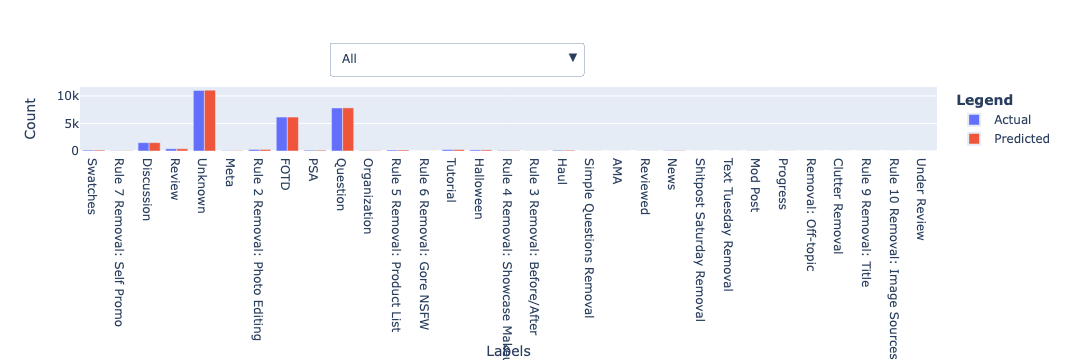

In [23]:
# Initialize the figure with grouped bar chart for the 'All' selection
fig = go.Figure(data=[
    go.Bar(name='Actual', x=merged_counts['ActualLabel'], y=merged_counts['ActualCount']),
    go.Bar(name='Predicted', x=merged_counts['ActualLabel'], y=merged_counts['PredictedCount'])
])

# Add a set of bars for each label, these will be hidden initially
for label in merged_counts['ActualLabel']:
    actual = merged_counts[merged_counts['ActualLabel'] == label]['ActualCount'].values[0]
    predicted = merged_counts[merged_counts['ActualLabel'] == label]['PredictedCount'].values[0]
    fig.add_trace(go.Bar(name=f'Actual - {label}', x=[label], y=[actual], visible=False))
    fig.add_trace(go.Bar(name=f'Predicted - {label}', x=[label], y=[predicted], visible=False))

# The initial button that shows all labels
buttons = [dict(label='All',
                method='update',
                args=[{'visible': [True, True] + [False] * (len(merged_counts) * 2),
                       'title': 'All'}])]

# Add buttons for each label in the dropdown
for i, label in enumerate(merged_counts['ActualLabel']):
    # Set visibility: only the two traces for the selected label are visible
    visibility = [False] * 2 + [i*2 == j or i*2+1 == j for j in range(len(merged_counts) * 2)]
    button = dict(label=label,
                  method='update',
                  args=[{'visible': visibility,
                         'title': label}])
    buttons.append(button)

# Update the layout with the dropdown
fig.update_layout(
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'active': 0,
        'x': 0.29,
        'y': 1.7,
        'xanchor': 'left',
        'yanchor': 'top'
    }],
    xaxis_title='Labels',
    yaxis_title='Count',
    barmode='group',
    legend_title='<b>Legend</b>',
    legend=dict(
        traceorder='normal',
        itemsizing='constant'
    )
)

# Show the figure
fig.show()

In [24]:
# Save the figure to an HTML file
html_file_path = '../../data/plots/title_classification_interactive_bar_chart.html'
fig.write_html(html_file_path)


Prediction Accuracy: 

The model seems to be highly accurate for most labels since the ActualCount and PredictedCount are very close. For example, posts tagged as "Swatches" have an actual count of 164 and a predicted count of 165, indicating the model's predictions are almost perfect.

Model Performance on Different Labels:

High Volume Labels: The model performs well on labels with a high number of posts, such as "Unknown", "FOTD" (Face of the Day), and "Question". This is expected as more data often leads to better model performance due to better learning of the patterns associated with these labels.
Low Volume Labels: For labels with very few posts, such as "Rule 6 Removal: Gore NSFW" and "Removal: Off-topic", the model still predicts accurately. However, it's worth noting that with such a small sample size, the model may not be as reliable due to the lack of data.


Error Analysis:

The largest discrepancy occurs in the "Unknown" category, with a difference of 50 between actual and predicted counts. This suggests that the model may be classifying some posts into "Unknown" that humans would not, or vice versa. It could be an indication of posts that are difficult to categorize or a sign that the model might be using certain features that lead to uncertainty.
For categories such as "Discussion", "Review", and "FOTD", the model has a slight over-prediction. While these differences are small, they may point to certain features or words that the model is keying on, which could lead to overfitting.

Consistency Across Categories:

The model shows consistency in prediction for many categories, such as "Meta", "Organization", "Rule 5 Removal: Product List", and "AMA", where the predicted count matches the actual count exactly.


Potential Improvements:

Investigating the features that lead to predictions for the "Unknown" category could improve the model's performance. It's possible that the model lacks sufficient discriminative power or that the "Unknown" category is a catch-all for posts that don't fit neatly into other categories.
For categories with larger discrepancies, a more detailed feature analysis could reveal why the model is making these errors. For instance, it could be over-relying on certain keywords or not capturing the context effectively.